In [ ]:
#|default_exp augment

# Augmentation

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [ ]:
set_seed(42)
lr,epochs = 6e-2,5

## Going wider

In [ ]:
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [ ]:
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.795,0.791,0,train
0.851,0.476,0,eval
0.885,0.417,1,train
0.877,0.358,1,eval
0.912,0.290,2,train
0.908,0.275,2,eval
0.935,0.215,3,train
0.922,0.260,3,eval
0.957,0.153,4,train
0.928,0.229,4,eval


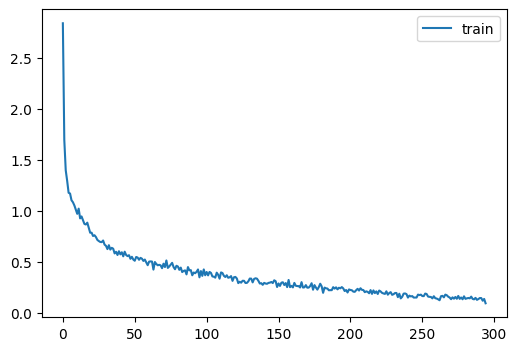

In [ ]:
learn.fit(epochs)

### Pooling

In [ ]:
class GlobalAvgPool(nn.Module):
    def forward(self, x): return x.mean((-2,-1))

In [ ]:
def get_model2(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [ResBlock(256, 512, act=act, norm=norm), GlobalAvgPool()]
    layers += [nn.Linear(512, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [ ]:
#|export
def _flops(x, h, w):
    if x.dim()<3: return x.numel()
    if x.dim()==4: return x.numel()*h*w
    raise Exception()

@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|MFLOPS|\n|--|--|--|--|--|\n'
    totp,totf = 0,0
    def _f(hook, mod, inp, outp):
        nonlocal res,totp,totf
        nparms = sum(o.numel() for o in mod.parameters())
        totp += nparms
        *_,h,w = outp.shape
        flops = sum(_flops(o, h, w) for o in mod.parameters())/1e6
        totf += flops
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|{flops:.1f}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, cbs=SingleBatchCB())
    print(f"Tot params: {totp}; MFLOPS: {totf:.1f}")
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [ ]:
TrainLearner(get_model2(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 4903556; MFLOPS: 33.0


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6864|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14432|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57536|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|229760|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|918272|3.7|
|ResBlock|(1024, 256, 2, 2)|(1024, 512, 2, 2)|3671552|14.7|
|GlobalAvgPool|(1024, 512, 2, 2)|(1024, 512)|0|0.0|
|Linear|(1024, 512)|(1024, 10)|5120|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.803,0.779,0,train
0.850,0.470,0,eval
0.886,0.414,1,train
0.839,0.460,1,eval
0.912,0.292,2,train
0.900,0.309,2,eval
0.932,0.219,3,train
0.921,0.273,3,eval
0.956,0.157,4,train
0.926,0.235,4,eval


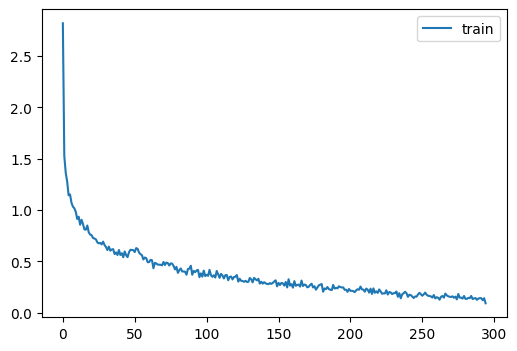

In [ ]:
set_seed(42)
model = get_model2(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
def get_model3(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [ ]:
TrainLearner(get_model3(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 1229444; MFLOPS: 18.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6864|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14432|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57536|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|229760|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|918272|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


In [ ]:
[o.shape for o in get_model3()[0].parameters()]

[torch.Size([16, 1, 5, 5]),
 torch.Size([16]),
 torch.Size([16, 16, 5, 5]),
 torch.Size([16]),
 torch.Size([16, 1, 1, 1]),
 torch.Size([16])]

accuracy,loss,epoch,train
0.782,0.845,0,train
0.825,0.505,0,eval
0.890,0.411,1,train
0.872,0.393,1,eval
0.915,0.287,2,train
0.902,0.295,2,eval
0.935,0.215,3,train
0.922,0.270,3,eval
0.956,0.160,4,train
0.931,0.229,4,eval


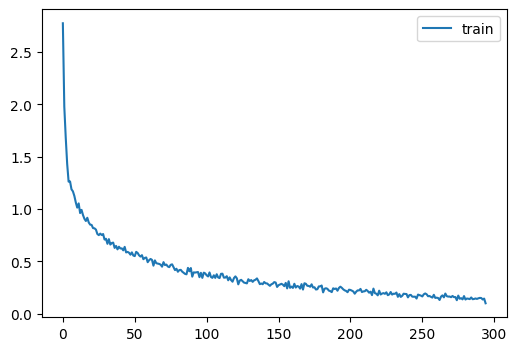

In [ ]:
set_seed(42)
model = get_model3(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
def get_model4(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [conv(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [ ]:
[o.shape for o in get_model4()[0].parameters()]

[torch.Size([16, 1, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16])]

In [ ]:
TrainLearner(get_model4(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 1223028; MFLOPS: 13.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(1024, 1, 28, 28)|(1024, 16, 28, 28)|448|0.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14432|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57536|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|229760|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|918272|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.796,0.798,0,train
0.855,0.521,0,eval
0.892,0.403,1,train
0.876,0.390,1,eval
0.915,0.285,2,train
0.899,0.296,2,eval
0.937,0.210,3,train
0.919,0.267,3,eval
0.960,0.150,4,train
0.926,0.240,4,eval


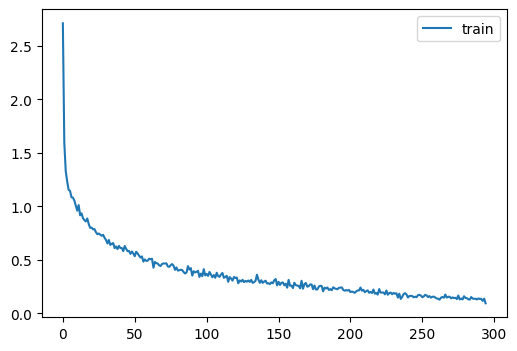

In [ ]:
set_seed(42)
model = get_model4(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

## Data augmentation

After 20 epochs without augmentation:

```
{'accuracy': '0.999', 'loss': '0.012', 'epoch': 19, 'train': True}
{'accuracy': '0.924', 'loss': '0.284', 'epoch': 19, 'train': False}
```

With batchnorm, weight decay doesn't really regularize.

In [ ]:
from torchvision import transforms

In [ ]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

tfms = nn.Sequential(transforms.RandomCrop(28, padding=4),
                     transforms.RandomHorizontalFlip())

augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])

In [ ]:
learn.fit(1)

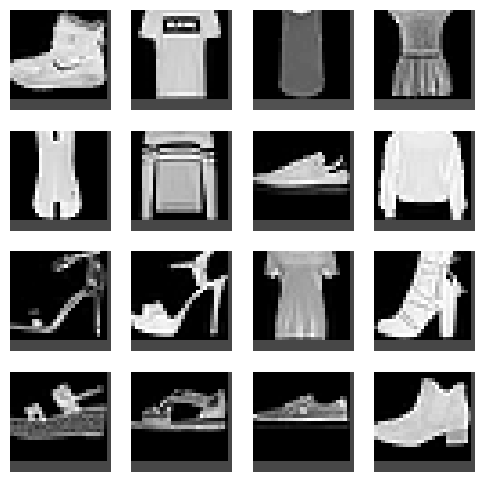

In [ ]:
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

In [ ]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

accuracy,loss,epoch,train
0.731,0.966,0,train
0.816,0.626,0,eval
0.843,0.634,1,train
0.824,0.609,1,eval
0.857,0.527,2,train
0.813,0.546,2,eval
0.867,0.447,3,train
0.840,0.485,3,eval
0.876,0.392,4,train
0.867,0.374,4,eval


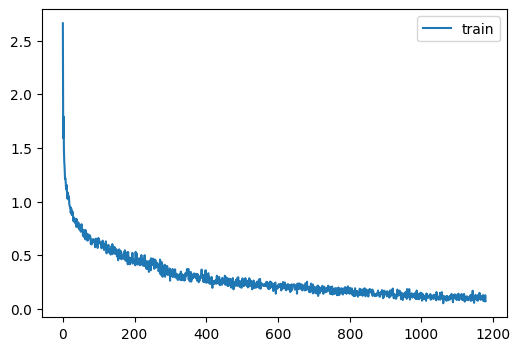

In [ ]:
set_seed(42)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

A custom collation function could let you do per-item transformations.

In [ ]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)
torch.save(learn.model, mdl_path/'data_aug.pkl')

## TTA

In [ ]:
#| export
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_preds,self.all_targs = [],[]
    def after_batch(self, learn):
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))

In [ ]:
#| export
@fc.patch
def capture_preds(self: Learner, cbs=None):
    cp = CapturePreds()
    self.fit(1, train=False, cbs=fc.L(cp)+fc.L(cbs))
    return torch.cat(cp.all_preds), torch.cat(cp.all_targs)

In [ ]:
ap1, at = learn.capture_preds()

accuracy,loss,epoch,train
0.941,0.180,0,eval


In [ ]:
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])

accuracy,loss,epoch,train
0.941,0.177,0,eval


In [ ]:
ap1.shape,ap2.shape,at.shape

(torch.Size([10000, 10]), torch.Size([10000, 10]), torch.Size([10000]))

In [ ]:
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)

In [ ]:
round((ap==at).float().mean().item(), 3)

0.942

## Random erase

In [ ]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]

In [ ]:
xm,xs = xbt.mean(),xbt.std()

In [ ]:
xbt.min(), xbt.max()

(tensor(-0.80), tensor(2.06))

In [ ]:
pct = 0.2

In [ ]:
szx = int(pct*xbt.shape[-2])
szy = int(pct*xbt.shape[-1])
stx = int(random.random()*(1-pct)*xbt.shape[-2])
sty = int(random.random()*(1-pct)*xbt.shape[-1])
stx,sty,szx,szy

(14, 0, 5, 5)

In [ ]:
init.normal_(xbt[:,:,stx:stx+szx,sty:sty+szy], mean=xm, std=xs);

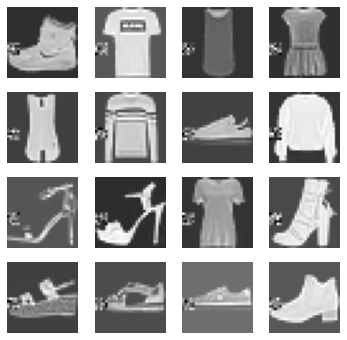

In [ ]:
show_images(xbt, imsize=1.5)

In [ ]:
xbt.min(), xbt.max()

(tensor(-2.98), tensor(3.19))

In [ ]:
#|export
def _rand_erase1(x, pct, xm, xs, mn, mx):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx = int(random.random()*(1-pct)*x.shape[-2])
    sty = int(random.random()*(1-pct)*x.shape[-1])
    init.normal_(x[:,:,stx:stx+szx,sty:sty+szy], mean=xm, std=xs)
    x.clamp_(mn, mx)

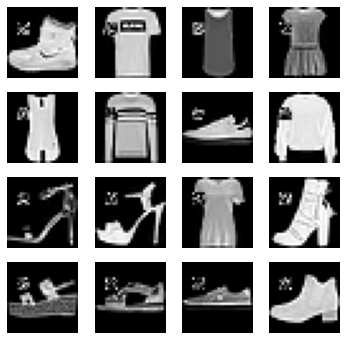

In [ ]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
_rand_erase1(xbt, 0.2, xbt.mean(), xbt.std(), xbt.min(), xbt.max())
show_images(xbt, imsize=1.5)

In [ ]:
xbt.mean(),xbt.std(),xbt.min(), xbt.max()

(tensor(-0.00), tensor(1.02), tensor(-0.80), tensor(2.06))

In [ ]:
#|export
def rand_erase(x, pct=0.2, max_num = 4):
    xm,xs,mn,mx = x.mean(),x.std(),x.min(),x.max()
    num = random.randint(0, max_num)
    for i in range(num): _rand_erase1(x, pct, xm, xs, mn, mx)
#     print(num)
    return x

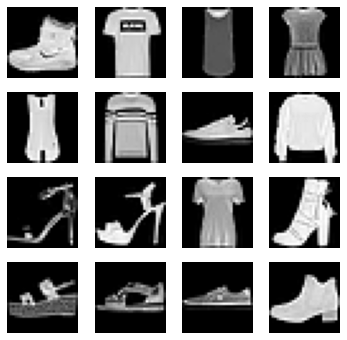

In [ ]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
rand_erase(xbt, 0.2, 4)
show_images(xbt, imsize=1.5)

In [ ]:
#|export
class RandErase(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_erase(x, self.pct, self.max_num)

In [ ]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

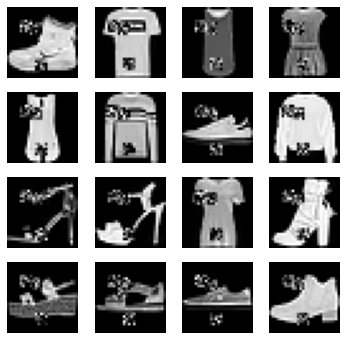

In [ ]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
learn.fit(1)
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

0.732,0.962,0,train
0.790,0.671,0,eval
0.828,0.667,1,train
0.819,0.600,1,eval
0.849,0.570,2,train
0.805,0.590,2,eval
0.857,0.505,3,train
0.855,0.445,3,eval
0.868,0.441,4,train
0.873,0.379,4,eval
0.861,0.437,5,train


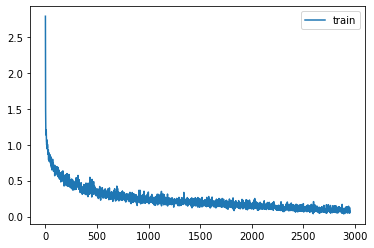

In [ ]:
epochs = 50
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

## Random copy

In [ ]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]

In [ ]:
szx = int(pct*xbt.shape[-2])
szy = int(pct*xbt.shape[-1])
stx1 = int(random.random()*(1-pct)*xbt.shape[-2])
sty1 = int(random.random()*(1-pct)*xbt.shape[-1])
stx2 = int(random.random()*(1-pct)*xbt.shape[-2])
sty2 = int(random.random()*(1-pct)*xbt.shape[-1])
stx1,sty1,stx2,sty2,szx,szy

(14, 0, 6, 4, 5, 5)

In [ ]:
xbt[:,:,stx1:stx1+szx,sty1:sty1+szy] = xbt[:,:,stx2:stx2+szx,sty2:sty2+szy]

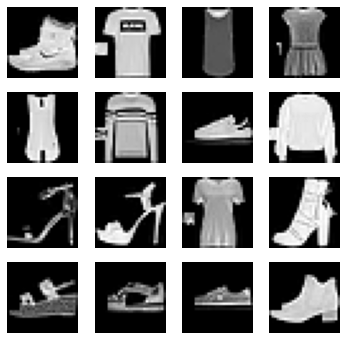

In [ ]:
show_images(xbt, imsize=1.5)

In [ ]:
#|export
def _rand_copy1(x, pct):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx1 = int(random.random()*(1-pct)*x.shape[-2])
    sty1 = int(random.random()*(1-pct)*x.shape[-1])
    stx2 = int(random.random()*(1-pct)*x.shape[-2])
    sty2 = int(random.random()*(1-pct)*x.shape[-1])
    x[:,:,stx1:stx1+szx,sty1:sty1+szy] = x[:,:,stx2:stx2+szx,sty2:sty2+szy]

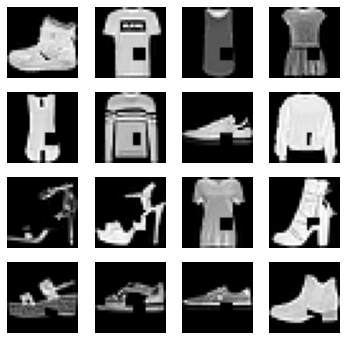

In [ ]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
_rand_copy1(xbt, 0.2)
show_images(xbt, imsize=1.5)

In [ ]:
#|export
def rand_copy(x, pct=0.2, max_num = 4):
    num = random.randint(0, max_num)
    for i in range(num): _rand_copy1(x, pct)
#     print(num)
    return x

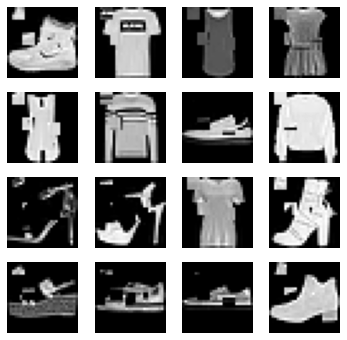

In [ ]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
rand_copy(xbt, 0.2, 4)
show_images(xbt, imsize=1.5)

In [ ]:
#|export
class RandCopy(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_copy(x, self.pct, self.max_num)

In [ ]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandCopy())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

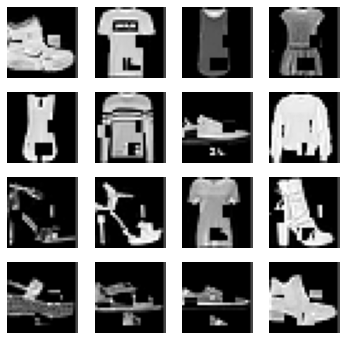

In [ ]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
learn.fit(1)
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

In [ ]:
@fc.patch
def show_image_batch(

SyntaxError: incomplete input (3980729758.py, line 2)

accuracy,loss,epoch,train
0.704,1.060,0,train
0.780,0.735,0,eval
0.808,0.734,1,train
0.810,0.603,1,eval
0.828,0.628,2,train
0.842,0.497,2,eval
0.837,0.559,3,train
0.836,0.520,3,eval
0.843,0.504,4,train
0.810,0.613,4,eval


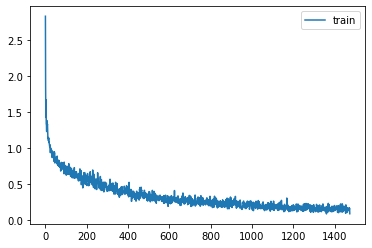

In [ ]:
set_seed(1)
epochs = 25
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train
0.704,1.042,0,train
0.780,0.675,0,eval
0.807,0.735,1,train
0.807,0.599,1,eval
0.832,0.622,2,train
0.837,0.495,2,eval
0.836,0.558,3,train
0.855,0.454,3,eval
0.855,0.469,4,train
0.865,0.439,4,eval


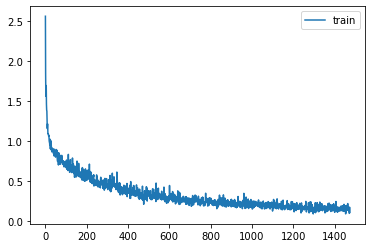

In [ ]:
model2 = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn2 = TrainLearner(model2, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn2.fit(epochs)

In [ ]:
mdl_path = Path('models')
torch.save(learn.model,  mdl_path/'randcopy1.pkl')
torch.save(learn2.model, mdl_path/'randcopy2.pkl')

In [ ]:
cp1 = CapturePreds()
learn.fit(1, train=False, cbs=cp1)

accuracy,loss,epoch,train
0.940,0.168,0,eval


In [ ]:
cp2 = CapturePreds()
learn2.fit(1, train=False, cbs=cp2)

accuracy,loss,epoch,train
0.941,0.170,0,eval


In [ ]:
ap1 = torch.cat(cp1.all_preds)
ap2 = torch.cat(cp2.all_preds)
at = torch.cat(cp1.all_targs)
ap1.shape,ap2.shape

(torch.Size([10000, 10]), torch.Size([10000, 10]))

In [ ]:
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)

In [ ]:
round((ap==at).float().mean().item(), 3)

0.944

### Export -

In [ ]:
import nbdev; nbdev.nbdev_export()